In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
from einops import rearrange, reduce, repeat

In [6]:
dataset_name = 'ravdess'
experiment_prefix = "scb12"
log_dir = f'../{experiment_prefix}_models/analysis/'
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
data_dir = "../data/data_preprocessed/"
sr = 16000


In [7]:
data_x = np.load(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.label_emotion_key.npy', allow_pickle=True)
filenames = np.load(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.filenames.npy', allow_pickle=True)
splits = np.load(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.splits.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(1440,)
(1440,)


array(['ang', 'cal', 'dis', 'fea', 'hap', 'neu', 'sad', 'sur'],
      dtype=object)

In [8]:
filenames[:3]

array(['Actor_01/03-01-01-01-01-01-01.wav',
       'Actor_01/03-01-01-01-01-02-01.wav',
       'Actor_01/03-01-01-01-02-01-01.wav'], dtype=object)

In [9]:
import pandas as pd

In [11]:
df = pd.read_csv(f'{data_dir}{dataset_name}/metadata/data_split.csv')
df


filename    emotion  speaker  gender intensity  \
0     Actor_01/03-01-01-01-01-01-01.wav    neutral        1    male    normal   
1     Actor_01/03-01-01-01-01-02-01.wav    neutral        1    male    normal   
2     Actor_01/03-01-01-01-02-01-01.wav    neutral        1    male    normal   
3     Actor_01/03-01-01-01-02-02-01.wav    neutral        1    male    normal   
4     Actor_01/03-01-02-01-01-01-01.wav       calm        1    male    normal   
...                                 ...        ...      ...     ...       ...   
1435  Actor_24/03-01-08-01-02-02-24.wav  surprised       24  female    normal   
1436  Actor_24/03-01-08-02-01-01-24.wav  surprised       24  female    strong   
1437  Actor_24/03-01-08-02-01-02-24.wav  surprised       24  female    strong   
1438  Actor_24/03-01-08-02-02-01-24.wav  surprised       24  female    strong   
1439  Actor_24/03-01-08-02-02-02-24.wav  surprised       24  female    strong   

      repetition                     statement statement_key emotion_key  \
0              1  Kids are talking by the door           KID         neu   
1              2  Kids are talking by the door           KID         neu   
2              1  Dogs are sitting by the door           DOG         neu   
3              2  Dogs are sitting by the door           DOG         neu   
4              1  Kids are talking by the door           KID         cal   
...          ...                           ...           ...         ...   
1435           2  Dogs are sitting by the door           DOG         sur   
1436           1  Kids are talking by the door           KID         sur   
1437           2  Kids are talking by the door           KID         sur   
1438           1  Dogs are sitting by the door           DOG         sur   
1439           2  Dogs are sitting by the door           DOG         sur   

      split  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
1435     11  
1436     11  
1437     11  
1438     11  
1439     11  

[1440 rows x 10 columns]

In [14]:
sum(df['filename'].values == filenames)

1440

In [15]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB12 as SCB
from omegaconf import OmegaConf as ocf

sr = 16000
batch_size = 2
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 768
num_tokens_per_second = 64
num_classes = 4
commitment_cost = 0.1
num_mamba_block=1

model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=cls_dim,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    num_mamba_block=num_mamba_block,
    num_tokens_per_second=num_tokens_per_second,
    max_num_tokens=max_num_tokens
)

In [29]:
def tokenize(X):
    X = torch.tensor(X, device=device)[None, None, :]
    tokens, _ = model.tokenize(X)
    return tokens.flatten().detach().cpu().numpy()

In [22]:
model.to(device)

SCB12(
  (classifier): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=512, bias=False)
    (2): PReLU(num_parameters=512)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
  (encoder): AudioVQEncoder(
    (tokenizer): SpeechSegmentSelector(
      (pad_fn): PadForConv()
    )
    (vq): AudioVQ(
      (embedding): VectorQuantizer(
        (embedding): Embedding(384, 511)
      )
    )
    (embedding): Embedding(384, 511, padding_idx=0)
    (positional_embedding): Embedding(768, 511)
  )
  (linear_projector): Linear(in_features=511, out_features=512, bias=False)
  (ssl_head): Linear(in_features=512, out_features=384, bias=True)
  (lstm_blocks): LSTM(512, 512, batch_first=True)
)

In [23]:
model.eval()

SCB12(
  (classifier): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=512, bias=False)
    (2): PReLU(num_parameters=512)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
  (encoder): AudioVQEncoder(
    (tokenizer): SpeechSegmentSelector(
      (pad_fn): PadForConv()
    )
    (vq): AudioVQ(
      (embedding): VectorQuantizer(
        (embedding): Embedding(384, 511)
      )
    )
    (embedding): Embedding(384, 511, padding_idx=0)
    (positional_embedding): Embedding(768, 511)
  )
  (linear_projector): Linear(in_features=511, out_features=512, bias=False)
  (ssl_head): Linear(in_features=512, out_features=384, bias=True)
  (lstm_blocks): LSTM(512, 512, batch_first=True)
)

In [30]:
tokenize(data_x[0])

array([231,  32,  14,  43,  14, 301,  70,  43, 258,  53, 330, 249, 130,
       249, 130, 249, 276, 194, 276, 274, 274, 134, 219, 349, 122,  67,
       115,  67, 226, 371, 163,  79,  40, 250,  61, 219, 349,  67, 115,
        67, 243, 165, 122,  32,  43, 253, 317,  97, 184,  73, 305, 184,
       164, 274,  30,  18, 332,  18, 258, 248, 130, 194, 276,  77, 194,
        18,  77, 122, 364,  53, 122,  61, 194, 122,  61, 115,  67, 115,
       305,  61, 122,  66, 212,  61, 122,  61,  93,  65, 134,  89,  67,
       212,  67, 290, 243,  54,  65,  65, 368, 317, 330, 368, 290, 140,
        60,  65,  89,  61,  93, 105, 243, 315, 262, 101, 315, 243, 128,
        65,  61,  93, 128, 243, 224,  54, 315, 212, 179, 193, 193, 193,
       114, 114, 114, 158,  55,  93,  89,  65,  89, 193, 114, 376, 315,
       315, 179,  65, 114,  65, 234,  74, 376, 315, 290, 224, 224, 234,
       234,  93,  55, 315, 114, 114, 158, 114, 114, 179, 114,  65, 193,
       114,  54, 158, 315, 179, 308, 179, 114, 114, 114, 114, 17

In [56]:
x0_tokens = tokenize(data_x[0])

In [32]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [33]:
emb = torch.load(model.codebook_pretrained_path)
emb_color, zcs = get_embedding_color_v2(emb)

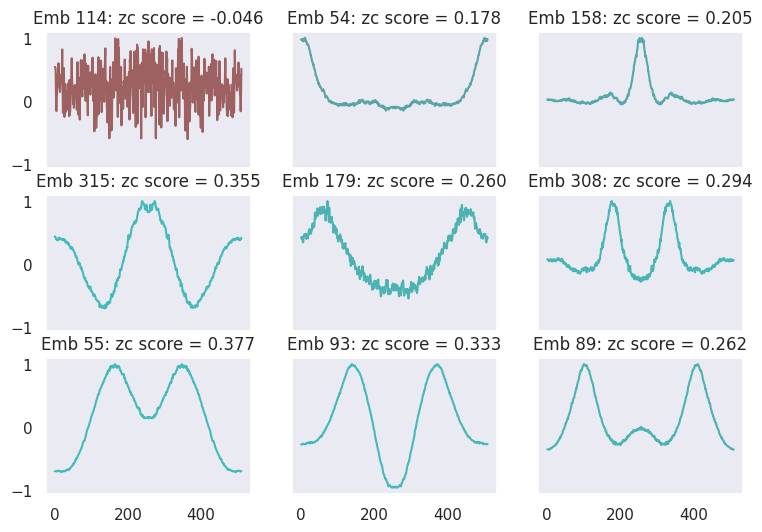

In [36]:
indices = [114,  54, 158, 315, 179, 308, 55,  93,  89]
fig, axes = plt.subplots(3, 3, figsize=(9,6), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = indices[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

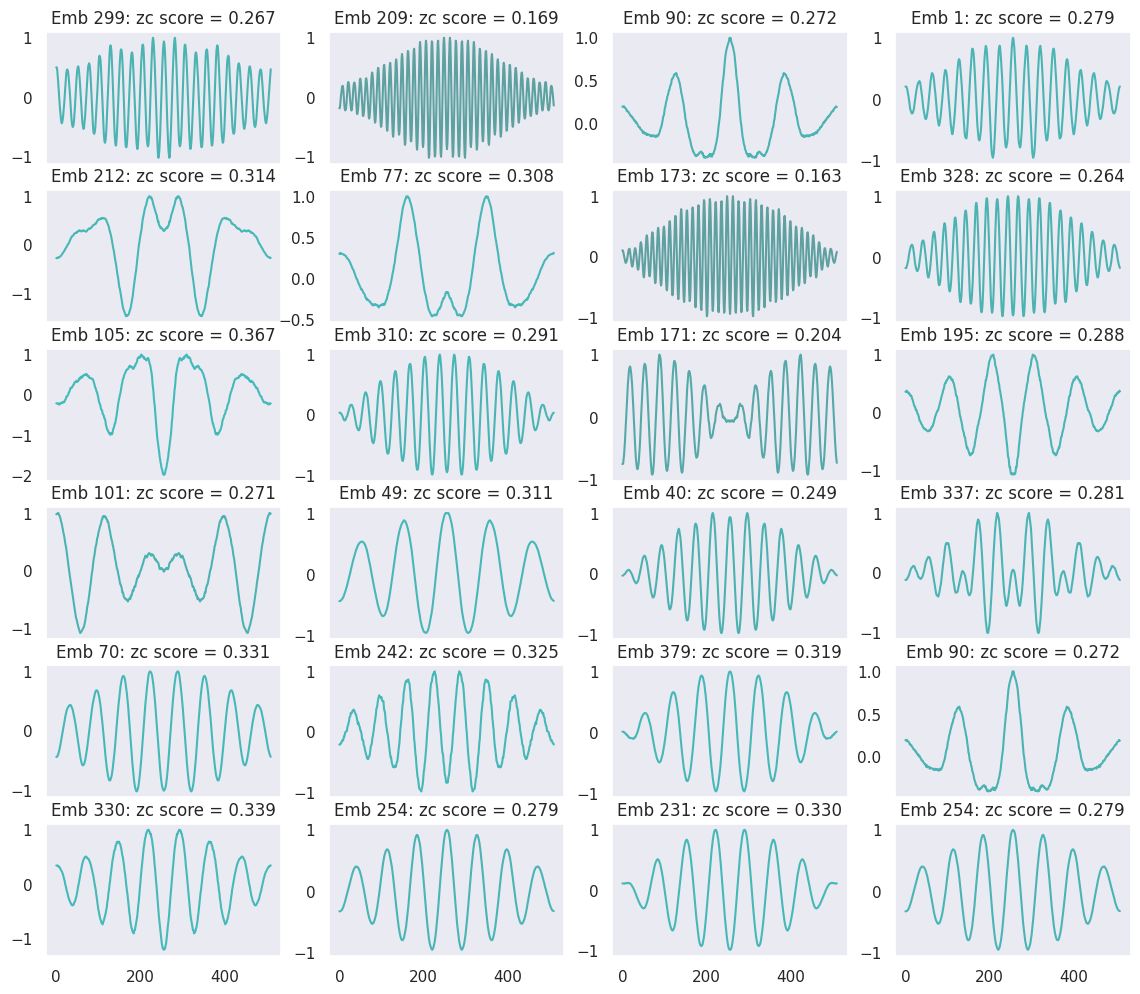

In [63]:
indices2 = x0_tokens[-24:]
fig, axes = plt.subplots(6, 4, figsize=(14,12), sharex=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = indices2[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

In [38]:
sum(zcs > 0)

tensor(316)

In [40]:
zcs.topk(k=80, largest=False)

torch.return_types.topk(
values=tensor([-0.2958, -0.2957, -0.2953, -0.2949, -0.2944, -0.2930, -0.2919, -0.2914,
        -0.2909, -0.2906, -0.2901, -0.2892, -0.2869, -0.2860, -0.2813, -0.2810,
        -0.2798, -0.2782, -0.2736, -0.2630, -0.2550, -0.2533, -0.2511, -0.2310,
        -0.2260, -0.2215, -0.2193, -0.2110, -0.2066, -0.2050, -0.2048, -0.2047,
        -0.2000, -0.1973, -0.1964, -0.1913, -0.1877, -0.1856, -0.1852, -0.1839,
        -0.1815, -0.1733, -0.1554, -0.1536, -0.1515, -0.1456, -0.1422, -0.1340,
        -0.1253, -0.1247, -0.1173, -0.1075, -0.1055, -0.1019, -0.0950, -0.0715,
        -0.0689, -0.0660, -0.0595, -0.0566, -0.0457, -0.0439, -0.0254, -0.0222,
        -0.0217, -0.0182, -0.0132, -0.0099,  0.0008,  0.0025,  0.0045,  0.0180,
         0.0189,  0.0218,  0.0332,  0.0367,  0.0368,  0.0435,  0.0448,  0.0511]),
indices=tensor([348,  88,  42, 362, 170, 206, 273, 267, 288,  37, 325, 369, 103,  92,
        321, 174, 182, 213, 282, 112,  85, 284, 272, 146, 256,  15, 283,  11,
  

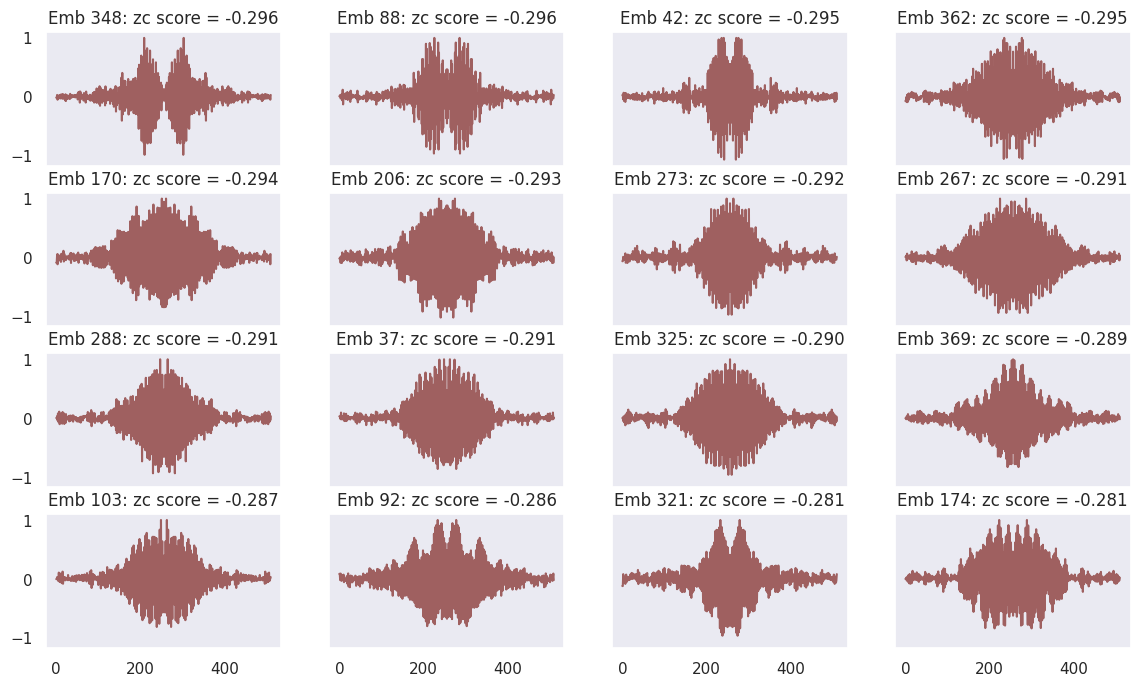

In [44]:
small_indices = zcs.topk(k=80, largest=False).indices[:-16]
fig, axes = plt.subplots(4, 4, figsize=(14,8), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = small_indices[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

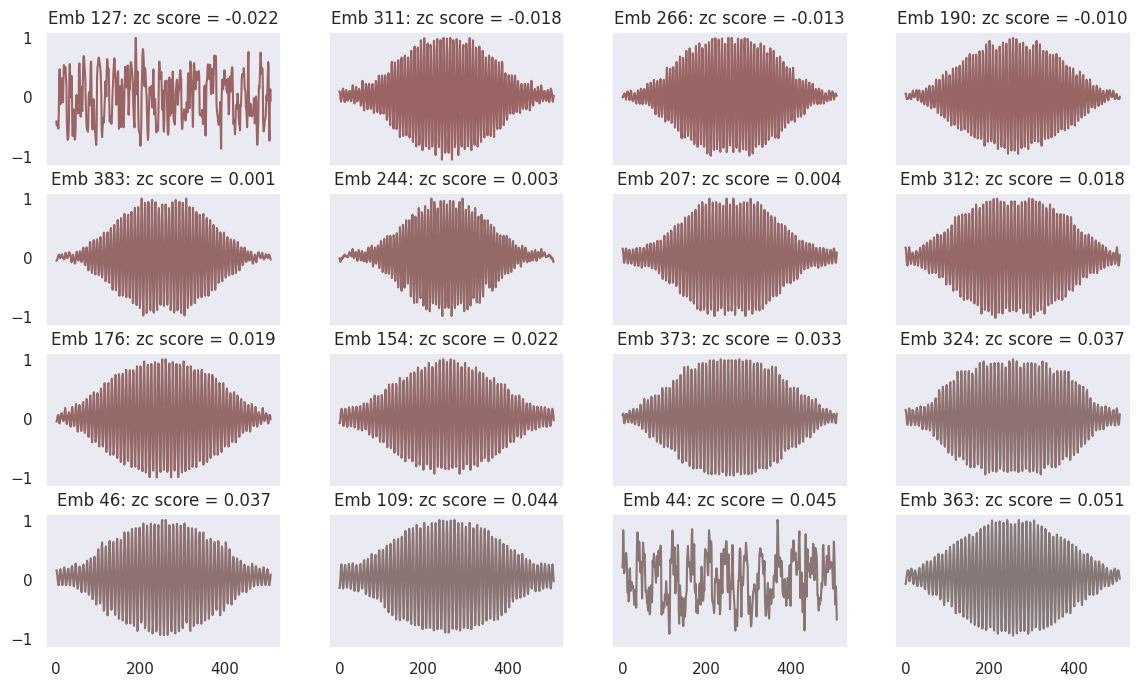

In [42]:
small_indices = [127, 311, 266, 190, 383, 244,
        207, 312, 176, 154, 373, 324,  46, 109,  44, 363]
fig, axes = plt.subplots(4, 4, figsize=(14,8), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = small_indices[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

tensor([0.0511, 0.0531, 0.0536, 0.0568, 0.0580, 0.0602, 0.0664, 0.0724, 0.0750,
        0.0750, 0.0753, 0.0774, 0.0819, 0.0857, 0.0865, 0.0940, 0.0972, 0.0978,
        0.1041, 0.1046, 0.1094, 0.1098, 0.1133, 0.1163])
tensor([306,  19, 110, 215, 177, 286, 264, 358, 235, 291, 119, 351, 280,  29,
        229, 135, 148,  75, 350, 353,   8, 230,  31, 175])


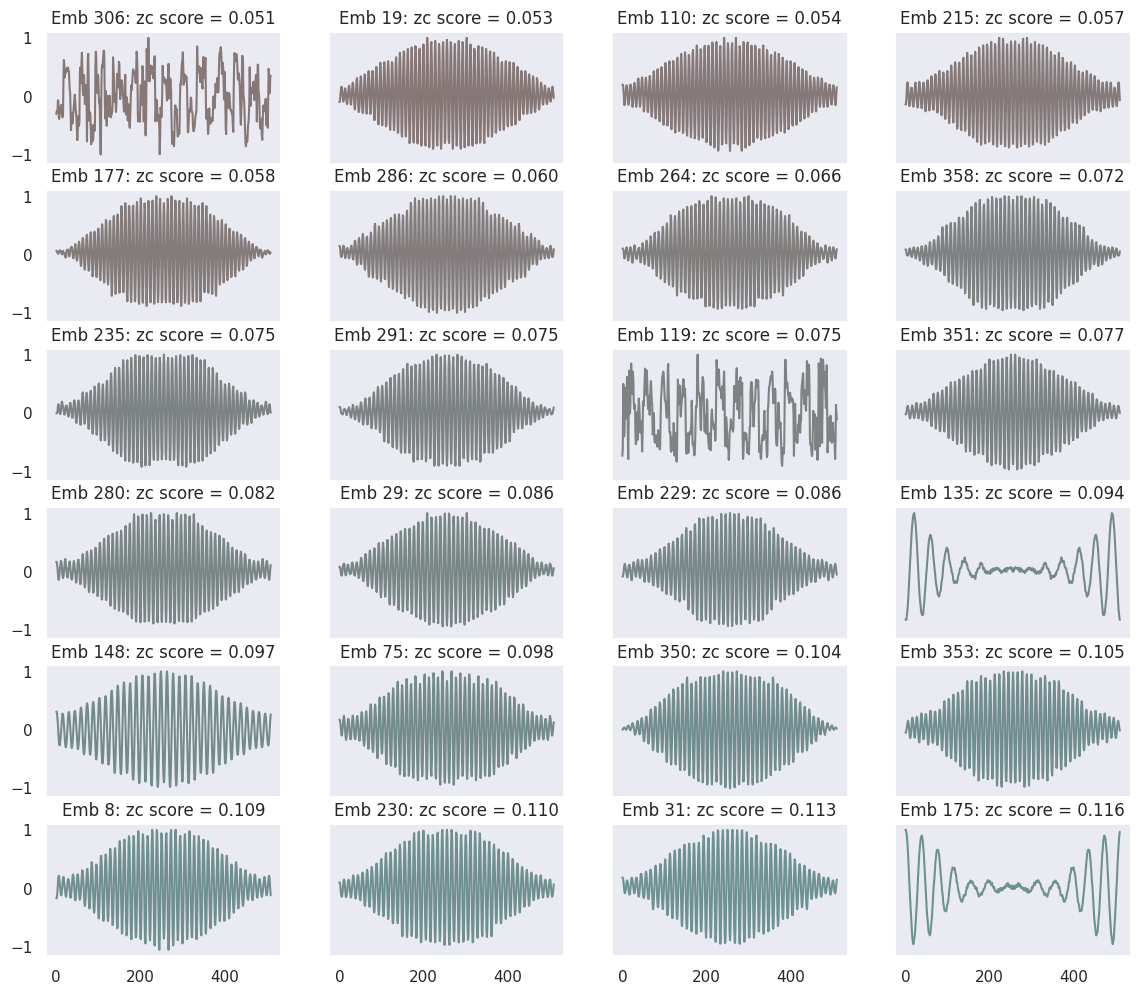

In [43]:
emd_indices = zcs.topk(k=104, largest=False)
print(emd_indices.values[-24:])
print(emd_indices.indices[-24:])
small_indices = emd_indices.indices[-24:]
fig, axes = plt.subplots(6, 4, figsize=(14,12), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = small_indices[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

In [49]:
from IConNet.nn.activation import nl_relu

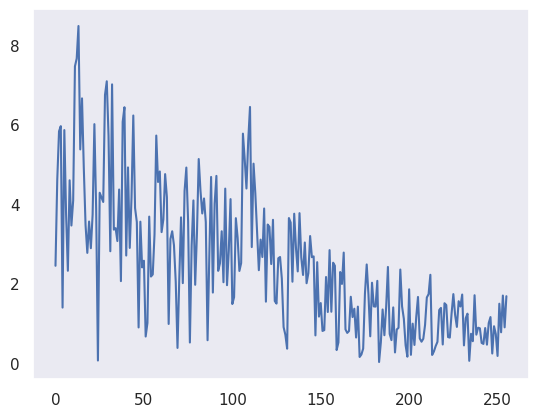

In [50]:
plt.plot(nl_relu(torch.fft.rfft(emb[306]).abs()**2))

(array([53., 53., 43., 34., 33., 18.,  9.,  8.,  3.,  2.]),
 array([0.02309798, 0.86830854, 1.7135191 , 2.55872965, 3.4039402 ,
        4.24915075, 5.09436131, 5.93957186, 6.78478241, 7.62999296,
        8.47520351]),
 <BarContainer object of 10 artists>)

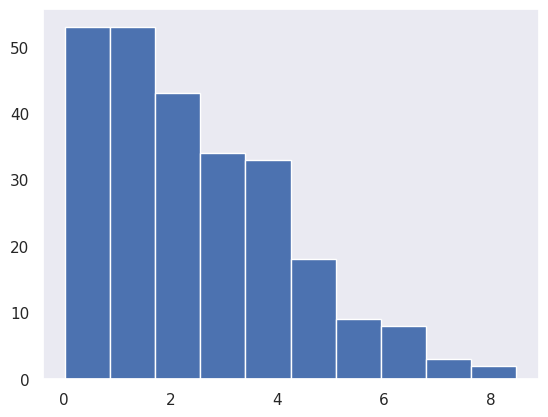

In [67]:
plt.hist(nl_relu(torch.fft.rfft(emb[306]).abs()**2).numpy())

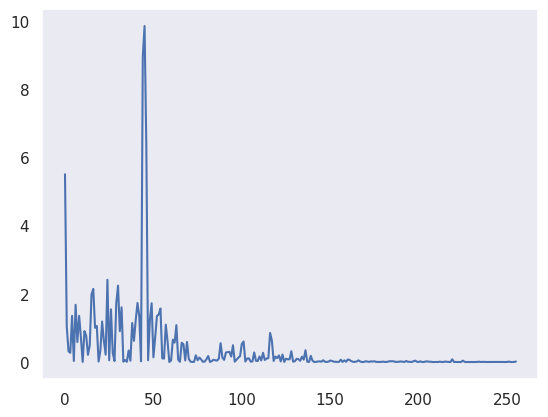

In [55]:
plt.plot(nl_relu(torch.fft.rfft(emb[31]).abs()**2))

(array([227.,  21.,   4.,   0.,   0.,   1.,   1.,   0.,   0.,   2.]),
 array([2.38418551e-07, 9.85180974e-01, 1.97036171e+00, 2.95554233e+00,
        3.94072318e+00, 4.92590380e+00, 5.91108465e+00, 6.89626551e+00,
        7.88144588e+00, 8.86662674e+00, 9.85180759e+00]),
 <BarContainer object of 10 artists>)

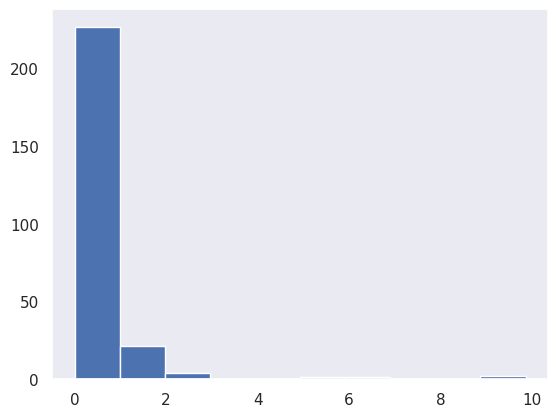

In [68]:
plt.hist(nl_relu(torch.fft.rfft(emb[31]).abs()**2).numpy())

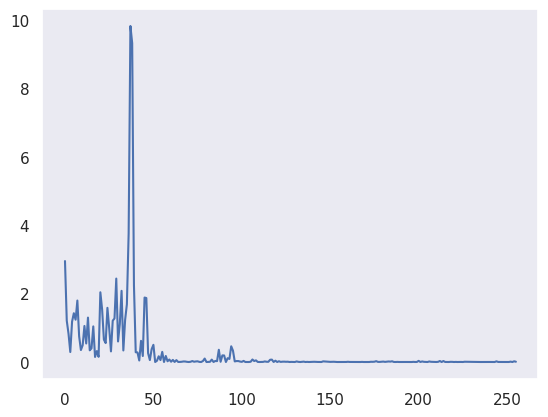

In [64]:
plt.plot(nl_relu(torch.fft.rfft(emb[173]).abs()**2))

(array([230.,  18.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.9834854 , 1.9669708 , 2.95045614, 3.9339416 ,
        4.91742706, 5.90091228, 6.88439798, 7.86788321, 8.8513689 ,
        9.83485413]),
 <BarContainer object of 10 artists>)

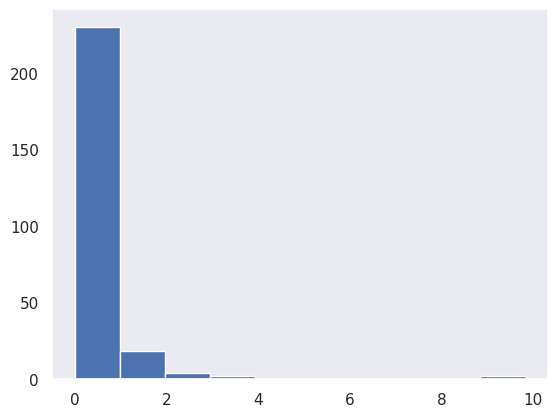

In [69]:
plt.hist(nl_relu(torch.fft.rfft(emb[173]).abs()**2).numpy())

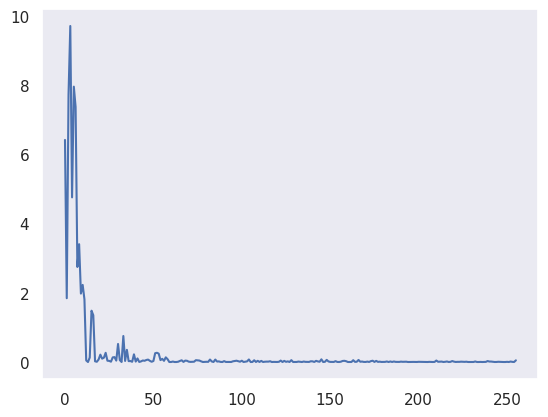

In [65]:
plt.plot(nl_relu(torch.fft.rfft(emb[77]).abs()**2))

(array([242.,   4.,   3.,   1.,   1.,   0.,   1.,   2.,   1.,   1.]),
 array([3.57627812e-07, 9.71797287e-01, 1.94359422e+00, 2.91539121e+00,
        3.88718820e+00, 4.85898495e+00, 5.83078194e+00, 6.80257893e+00,
        7.77437592e+00, 8.74617290e+00, 9.71796989e+00]),
 <BarContainer object of 10 artists>)

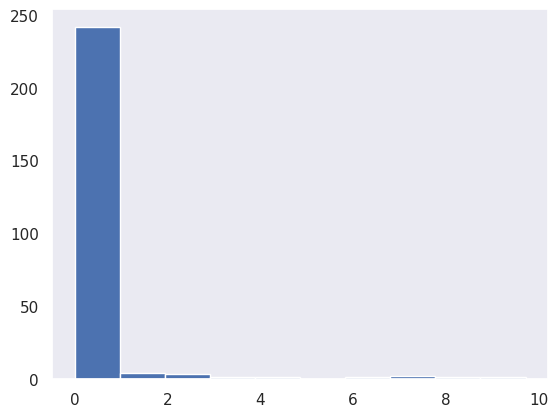

In [70]:
plt.hist(nl_relu(torch.fft.rfft(emb[77]).abs()**2).numpy())

(array([237.,   7.,   4.,   3.,   1.,   0.,   0.,   1.,   1.,   2.]),
 array([6.79490631e-06, 9.12502408e-01, 1.82499802e+00, 2.73749352e+00,
        3.64998913e+00, 4.56248474e+00, 5.47498035e+00, 6.38747597e+00,
        7.29997158e+00, 8.21246719e+00, 9.12496281e+00]),
 <BarContainer object of 10 artists>)

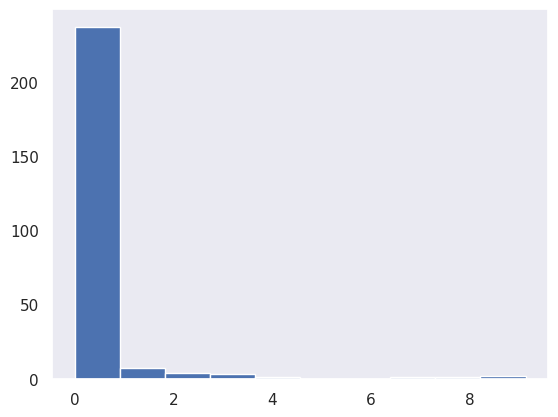

In [71]:
plt.hist(nl_relu(torch.fft.rfft(emb[175]).abs()**2).numpy())

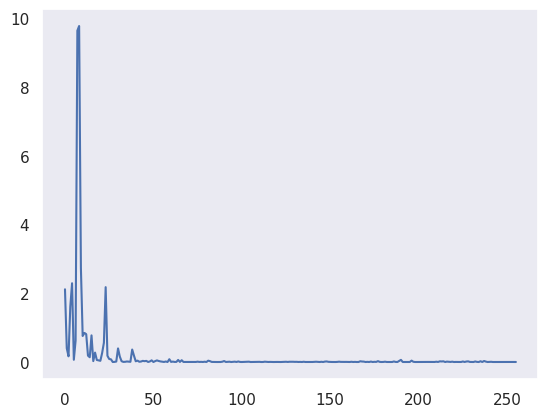

In [66]:
plt.plot(nl_relu(torch.fft.rfft(emb[379]).abs()**2))

In [72]:
emb_fft_db = nl_relu(torch.fft.rfft(emb).real**2)

In [81]:
torch.where(emb_fft_db<=0.5, 1, 0).sum(dim=-1)

tensor([224, 225, 245, 244, 191, 242, 218, 238, 211, 228, 249, 160, 235, 250,
        224, 160, 230, 238, 244, 204, 240, 211, 238, 218, 204, 177, 241, 236,
        233, 220, 243, 214, 241, 225, 235, 228, 242, 214, 215, 221, 242, 244,
        211, 234,  85, 223, 207, 173, 224, 245, 243, 241, 253, 236, 235, 245,
        219, 236, 242, 221, 247, 230, 235, 232, 169, 222, 242, 245, 237, 230,
        245, 165, 225, 244, 238, 207, 208, 240, 253, 241, 221, 251, 247, 224,
        242, 163, 240, 233, 215, 244, 240, 220, 189, 245, 224, 189, 245, 218,
        237, 171, 223, 233, 228, 197, 231, 222, 217, 250, 241, 211, 204, 231,
        173, 233,  64, 243, 235, 212, 180,  66, 233, 243, 236, 166, 240, 250,
        213,  90, 221, 181, 239, 229, 243, 217, 229, 223, 244, 235, 234, 211,
        246, 243, 187, 243, 226, 226, 191, 229, 228, 242, 218, 237,  80, 224,
        211, 187, 253, 231, 235, 246, 243, 231, 219, 231, 247, 240, 240, 240,
        226, 233, 217, 232, 187, 223, 168, 230, 215, 211, 227, 1

In [84]:
torch.where(emb_fft_db<=0.5, 1, 0).sum(dim=-1).topk(k=64, largest=False)

torch.return_types.topk(
values=tensor([ 64,  66,  80,  84,  85,  90, 160, 160, 161, 161, 163, 163, 163, 165,
        166, 168, 169, 169, 170, 171, 171, 171, 171, 172, 173, 173, 173, 174,
        176, 176, 177, 177, 178, 178, 179, 180, 180, 181, 181, 184, 184, 185,
        186, 187, 187, 187, 189, 189, 189, 191, 191, 191, 191, 192, 193, 194,
        194, 197, 197, 198, 199, 200, 201, 201]),
indices=tensor([114, 119, 152, 306,  44, 127,  15,  11, 356, 256, 217, 263,  85,  71,
        123, 174, 336,  64, 283,  99, 370, 225, 289, 261,  47, 268, 112, 307,
        321, 197,  25, 189, 287, 272, 382, 118, 213, 323, 129, 179, 282, 182,
        284, 142, 155, 172,  92,  95, 203, 245, 244, 146,   4, 354, 206, 228,
        311, 103, 247, 266, 260, 334, 383, 292]))

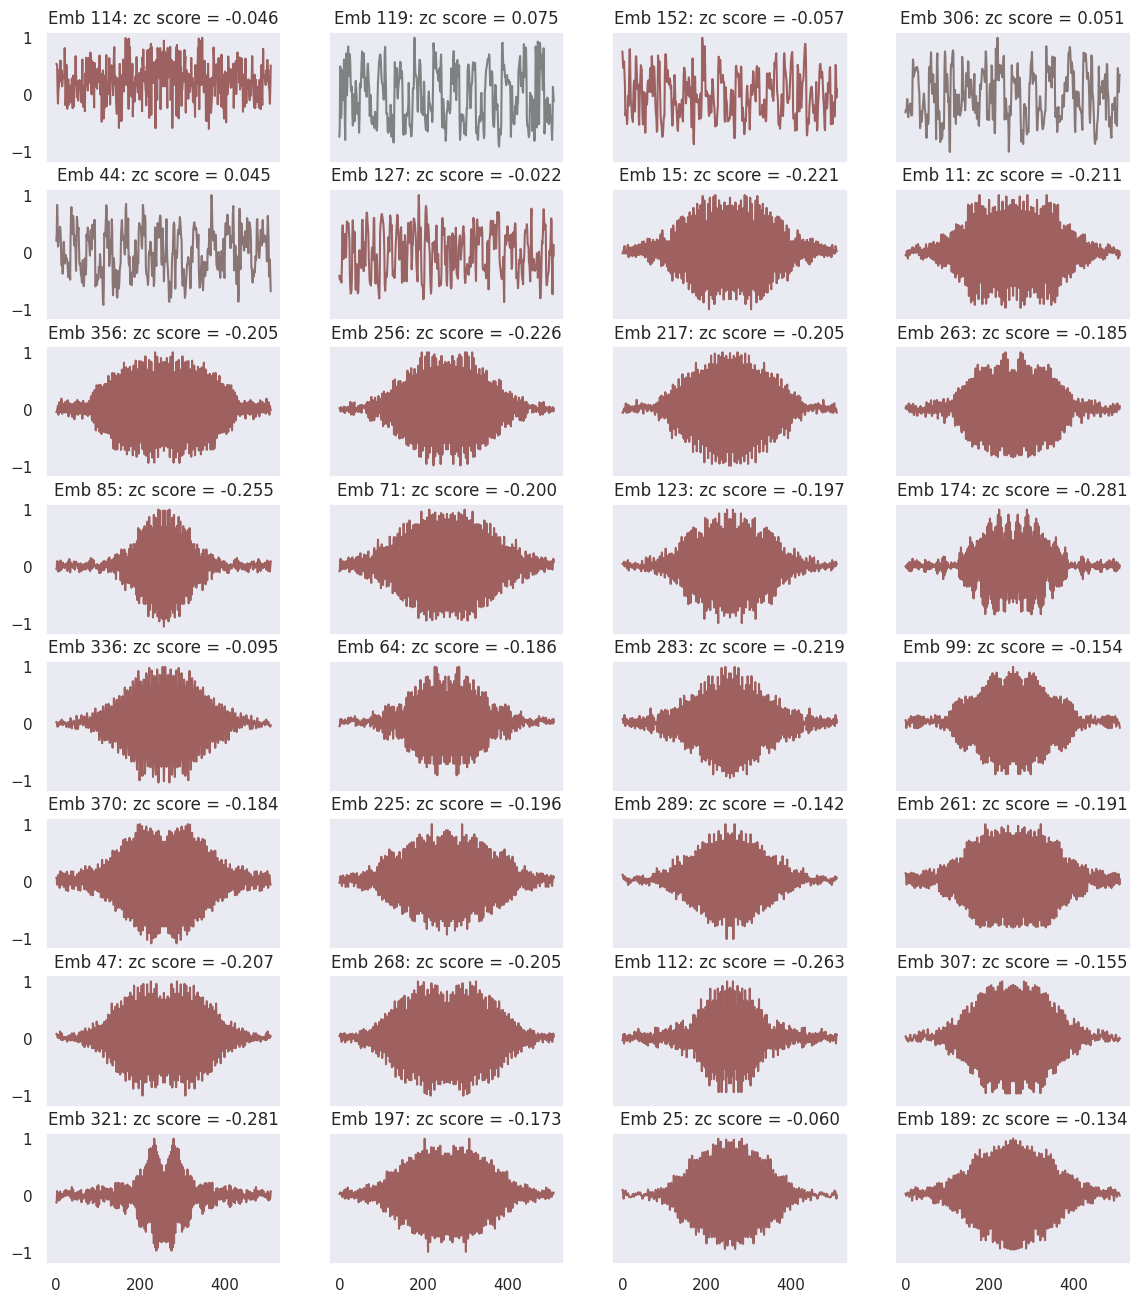

In [85]:
fft_indices = torch.where(emb_fft_db<=0.5, 1, 0).sum(dim=-1).topk(k=64, largest=False).indices
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = fft_indices[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

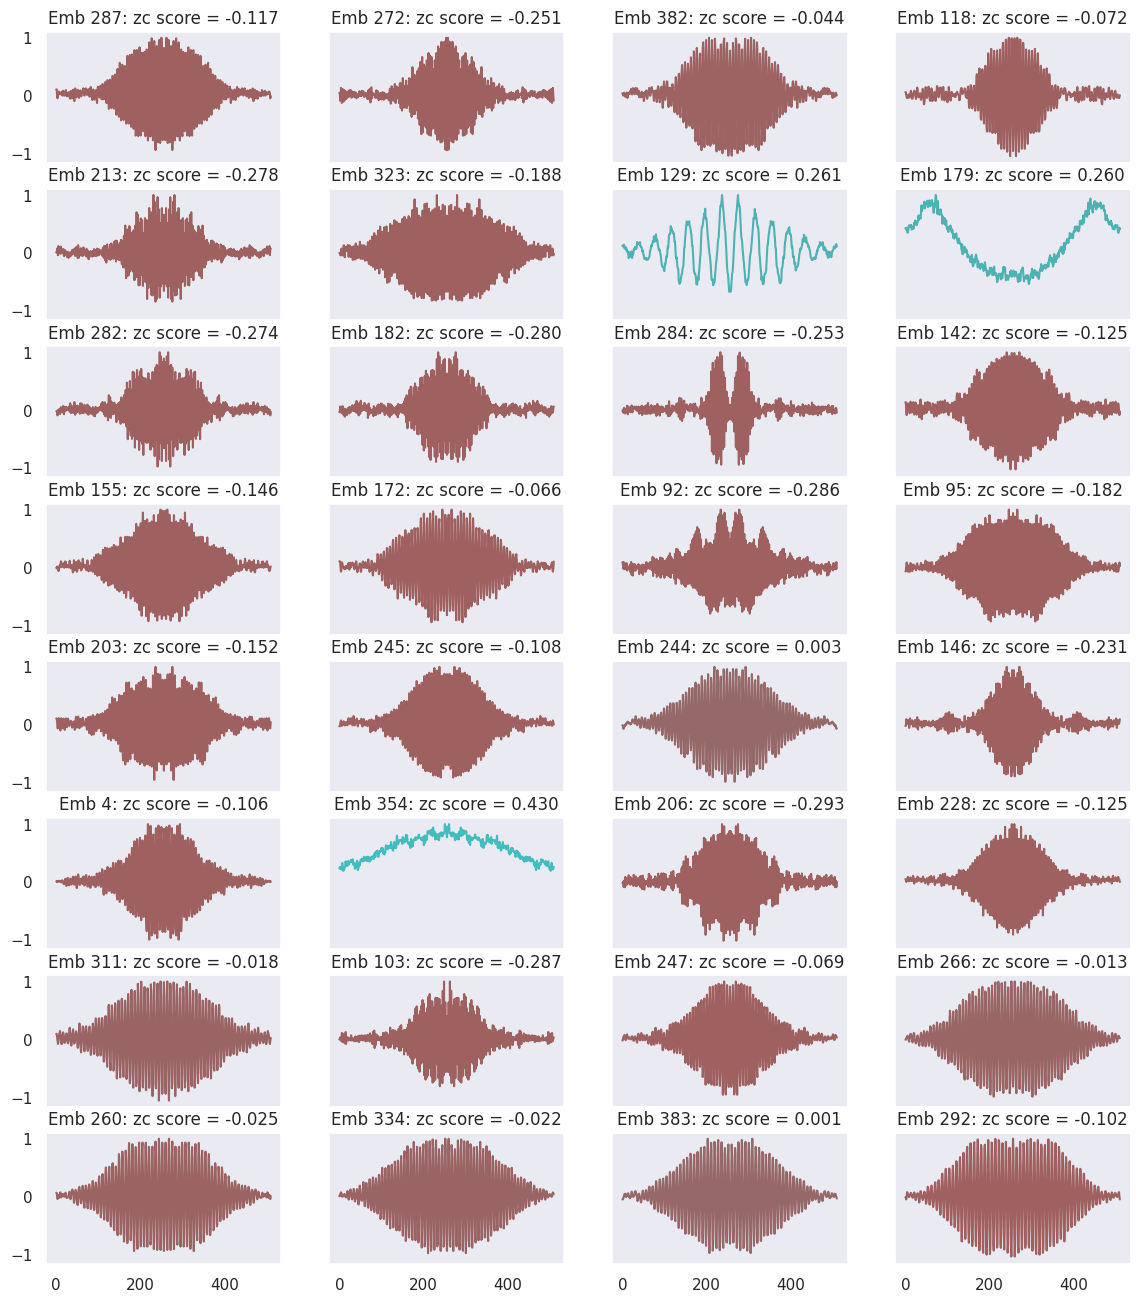

In [86]:
fft_indices = torch.where(emb_fft_db<=0.5, 1, 0).sum(dim=-1).topk(k=64, largest=False).indices
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = fft_indices[32+i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

In [87]:
fft_score = torch.where(emb_fft_db<=0.5, 1, 0).sum(dim=-1)

In [91]:
noise_mask = torch.logical_or(zcs <= 0, fft_score <= 100)

In [92]:
sum(noise_mask)

tensor(71)

In [95]:
emb.shape

torch.Size([384, 511])

In [118]:
masked_emb = torch.einsum('bh,b->bh', emb,torch.logical_not(noise_mask))

In [119]:
model.encoder.vq.embedding.embedding.weight.data = masked_emb.clone().to(device)

In [120]:
data_x_tokens = [tokenize(d) for d in data_x]

In [121]:
all_tokens_list = np.concatenate(data_x_tokens)

In [122]:
all_tokens_list

array([ 76,  32,  14, ..., 253, 253, 310])

In [108]:
from collections import Counter

In [123]:
tokens_counter = Counter(all_tokens_list)
tokens_counter

Counter({4: 231624,
         158: 10125,
         156: 9337,
         52: 7221,
         78: 7132,
         82: 6717,
         50: 6125,
         187: 5764,
         257: 5757,
         380: 5579,
         179: 5510,
         134: 5322,
         129: 5181,
         140: 5138,
         317: 5061,
         354: 4995,
         318: 4982,
         122: 4823,
         90: 4743,
         355: 4284,
         107: 4217,
         76: 4184,
         308: 4152,
         54: 3971,
         159: 3692,
         16: 3611,
         143: 3569,
         157: 3546,
         349: 3537,
         368: 3405,
         195: 3379,
         344: 3344,
         221: 3270,
         193: 3123,
         254: 3098,
         329: 3042,
         181: 3022,
         220: 3008,
         1: 2998,
         10: 2975,
         341: 2907,
         67: 2897,
         108: 2786,
         271: 2771,
         219: 2701,
         262: 2681,
         77: 2636,
         22: 2565,
         274: 2550,
         125: 2509,
         364:

In [124]:
tokens_counter.most_common(24)

[(4, 231624),
 (158, 10125),
 (156, 9337),
 (52, 7221),
 (78, 7132),
 (82, 6717),
 (50, 6125),
 (187, 5764),
 (257, 5757),
 (380, 5579),
 (179, 5510),
 (134, 5322),
 (129, 5181),
 (140, 5138),
 (317, 5061),
 (354, 4995),
 (318, 4982),
 (122, 4823),
 (90, 4743),
 (355, 4284),
 (107, 4217),
 (76, 4184),
 (308, 4152),
 (54, 3971)]

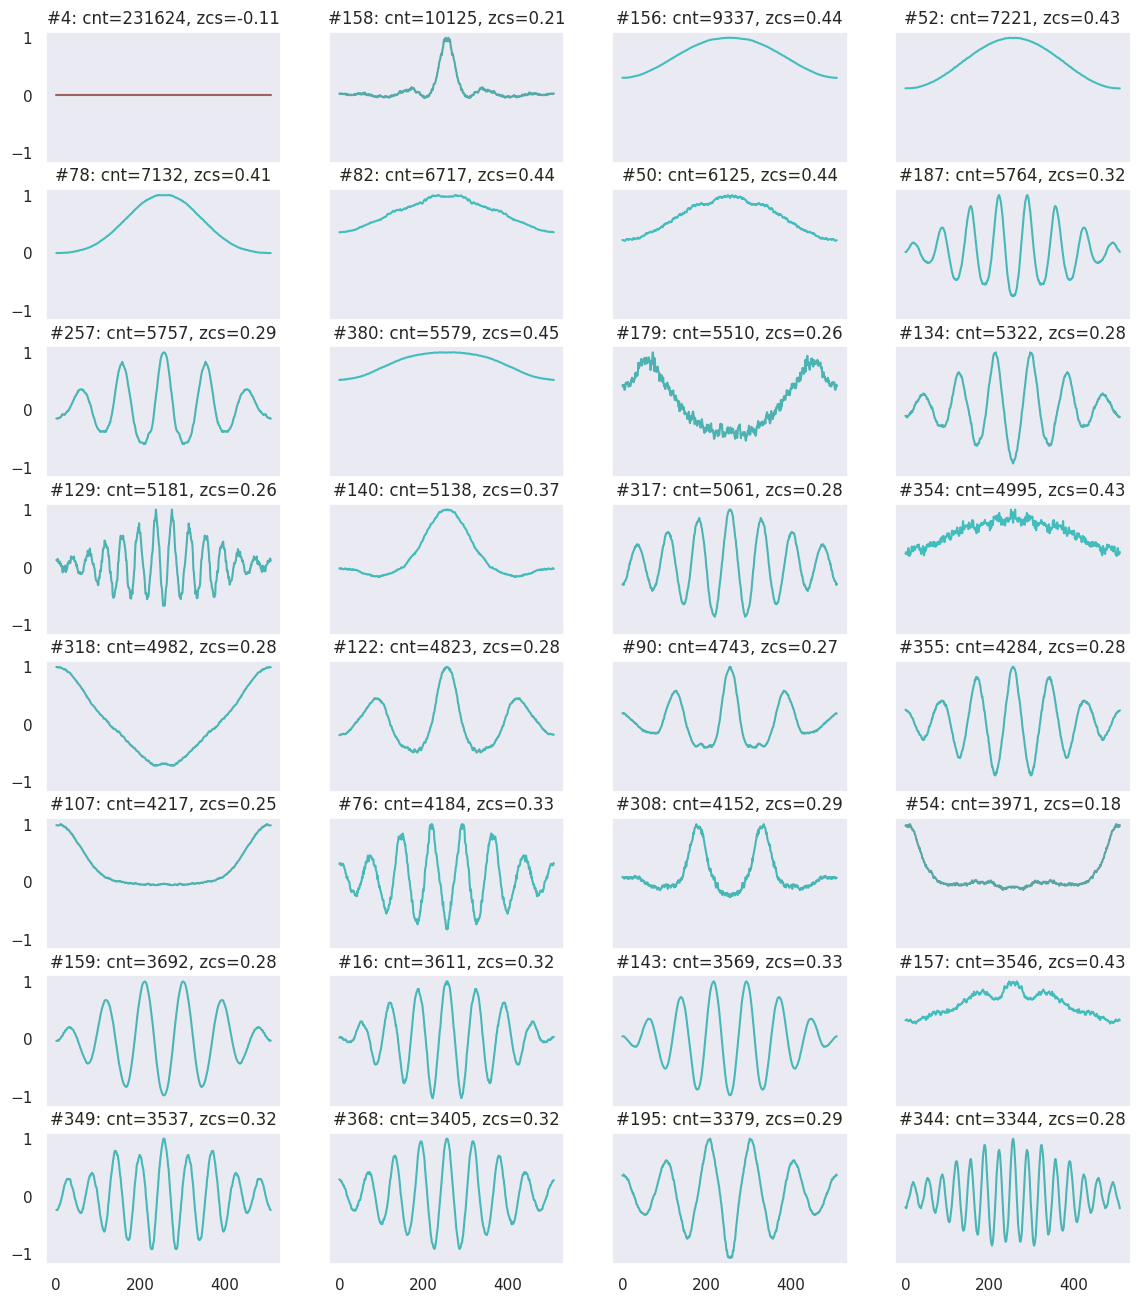

In [128]:
top_counter = tokens_counter.most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = top_counter[i]
    ax.plot(masked_emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

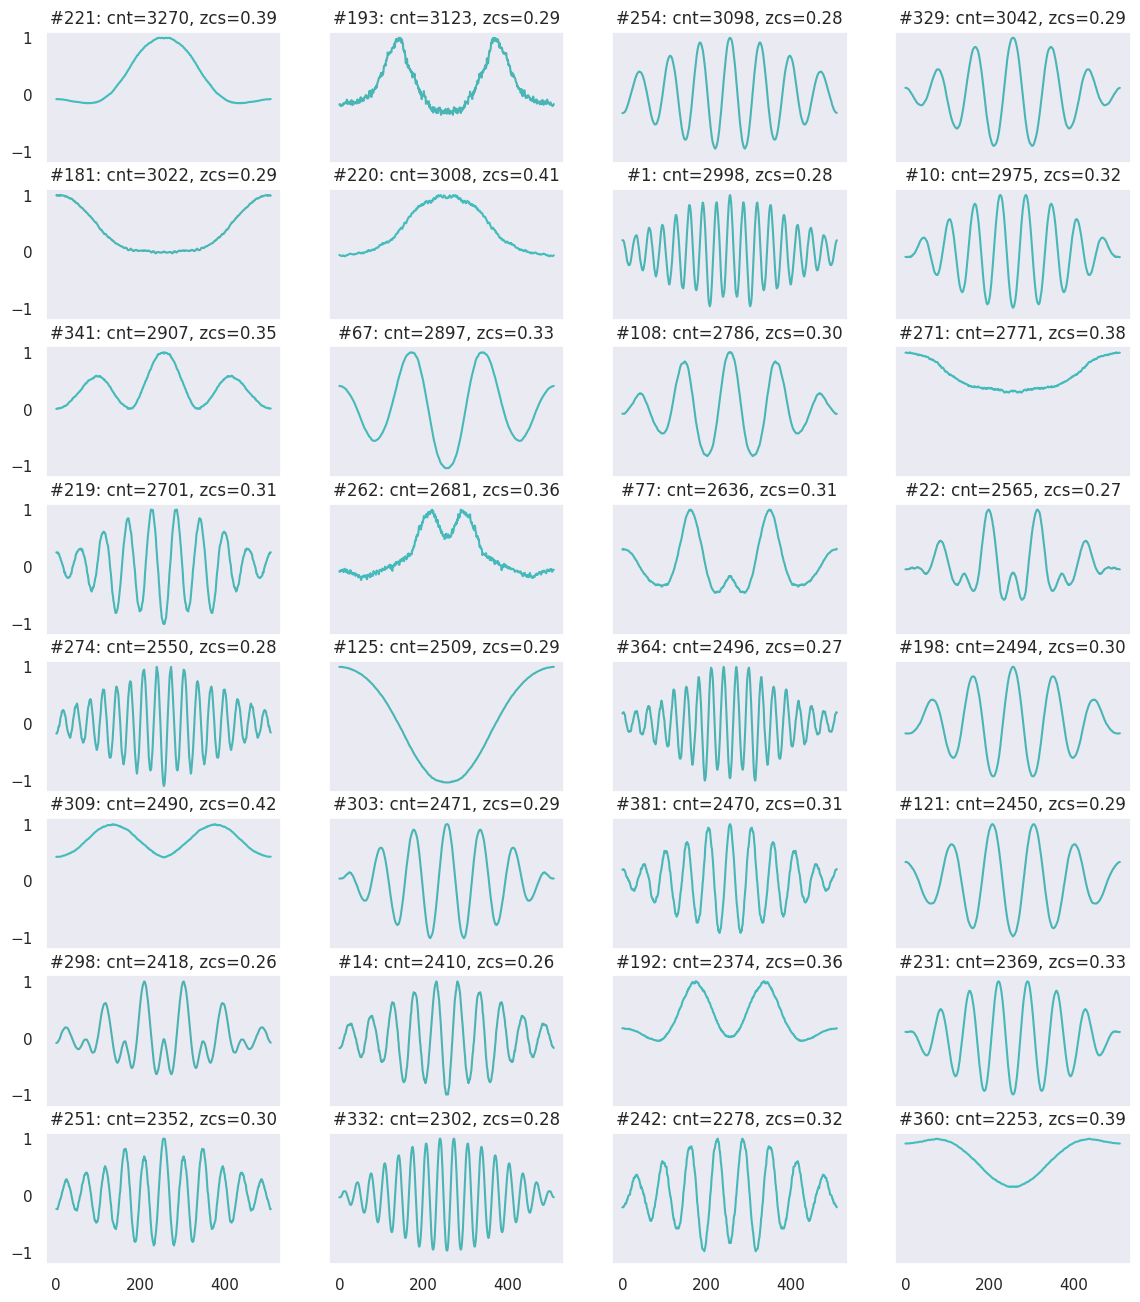

In [126]:
top_counter = tokens_counter.most_common(64)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = top_counter[32+i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

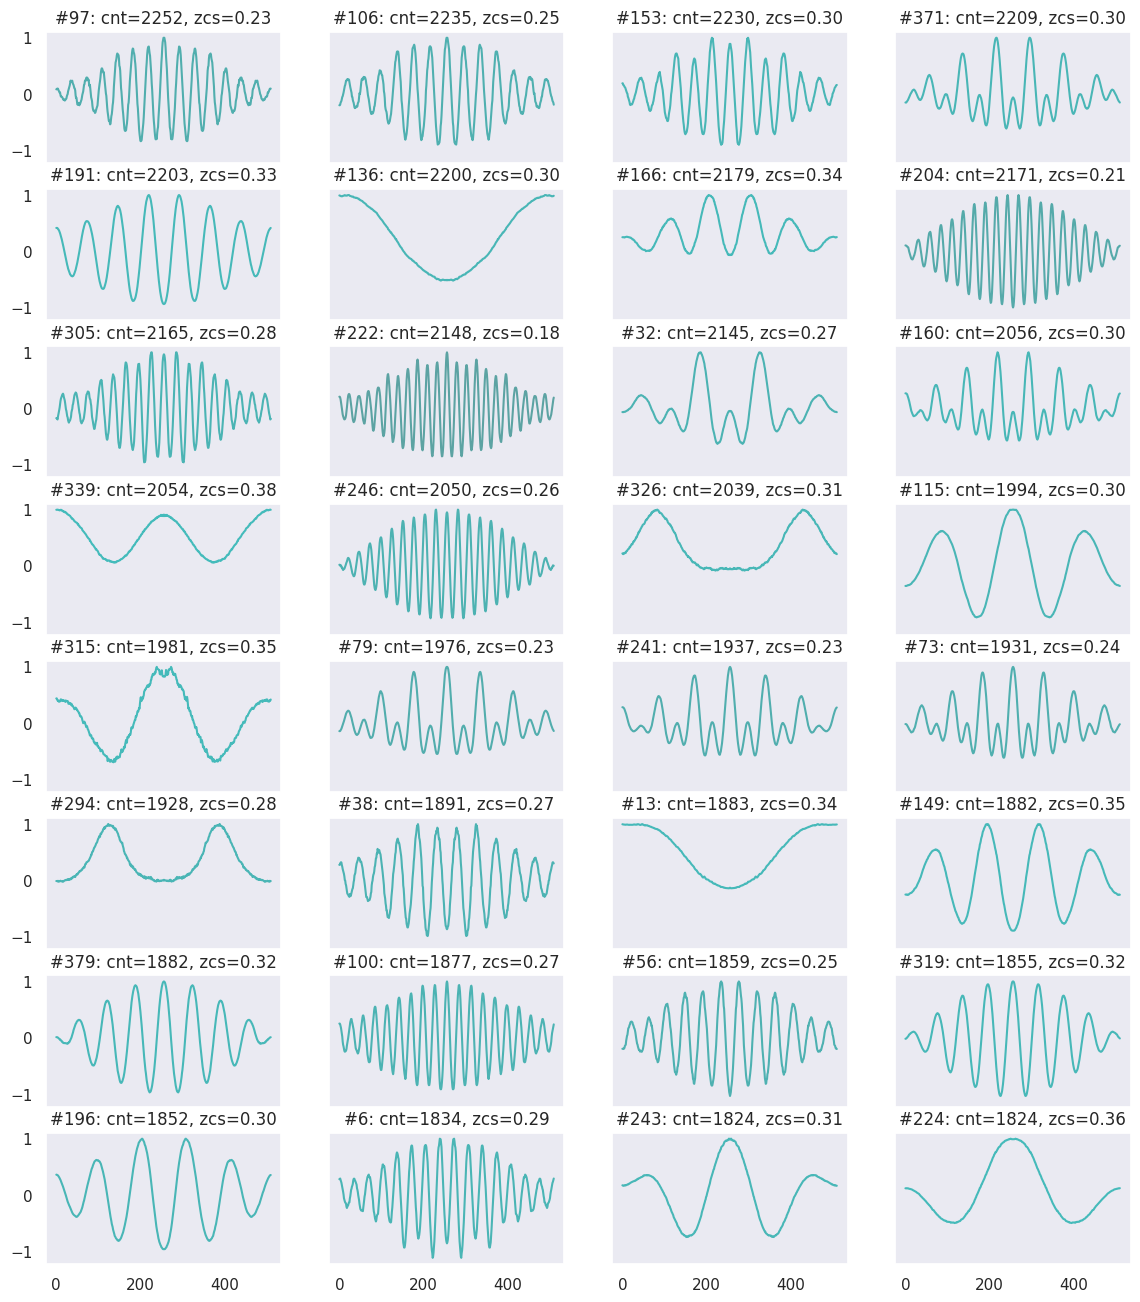

In [127]:
top_counter = tokens_counter.most_common(64+32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = top_counter[32+32+i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

In [130]:
data_x_tokens

[array([ 76,  32,  14,  14,  14, 301, 187, 135, 258,  53,  76, 249, 130,
        249, 364, 305, 364, 305, 364,   4,   4,   4, 219,  77, 122, 308,
        122,  77, 122, 371, 129,  79,  40, 153,   4, 219, 349,  77, 122,
         67, 243,  90, 122,  32,   4, 327, 317,  97, 367,  73, 305,   4,
        164,   4,  30,  18, 332,  18,   6, 344, 130, 305, 364,  77, 305,
         18,  77, 122,   4,  53, 122,  77, 305, 122,  67, 115,  66, 122,
          4,  77, 122, 308,  90,   4, 122, 308, 193, 193, 134,  89,  67,
        212,  77, 315, 243,  54,   4, 193,   4, 317, 160, 368, 315, 140,
         60,  77,  89, 193,  89, 308,   4,   4,   4,  54, 315, 243,  54,
        193,   4, 193, 179, 243, 224,  54,   4, 134,   4,   4,   4,   4,
          4,   4,   4, 158, 193, 193,  89, 193,   4,   4,   4,  54, 224,
        243,   4,   4,   4,   4, 179,  89, 308, 315, 290, 315, 315, 234,
         93,  93, 262,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
          4,  54, 158, 243,   4,   4,   4,   4,   4

In [131]:
tokens_counter[0]

299

In [134]:
padded_tensors = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(d, dtype=torch.int) for d in data_x_tokens],
    batch_first=True, padding_value=-1)

In [135]:
padded_tensors.shape

torch.Size([1440, 675])

In [136]:
np.save(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.tokens.npy', padded_tensors.numpy(), allow_pickle=True)

In [137]:
torch.save(masked_emb, f'../scb11_models/ravdess/epoch=220.masked_codebook.pt')

In [138]:
df['tokens'] = data_x_tokens

In [141]:
hap_tokens = np.concatenate(df[df['emotion_key']=='hap']['tokens'].values)

In [142]:
hap_tokens_counter = Counter(hap_tokens)
hap_tokens_counter

Counter({4: 28833,
         158: 1351,
         156: 1150,
         52: 996,
         78: 955,
         82: 899,
         50: 861,
         354: 811,
         380: 800,
         179: 763,
         187: 726,
         257: 711,
         318: 645,
         134: 634,
         317: 622,
         140: 591,
         157: 585,
         129: 561,
         107: 541,
         76: 539,
         355: 534,
         349: 516,
         344: 510,
         16: 490,
         122: 488,
         54: 483,
         159: 479,
         308: 475,
         10: 454,
         341: 451,
         195: 450,
         1: 444,
         143: 439,
         368: 430,
         90: 424,
         221: 415,
         364: 406,
         219: 399,
         271: 388,
         193: 379,
         254: 379,
         329: 378,
         262: 377,
         220: 373,
         204: 373,
         181: 372,
         332: 370,
         305: 366,
         381: 366,
         14: 364,
         274: 350,
         246: 339,
         222: 339,
   

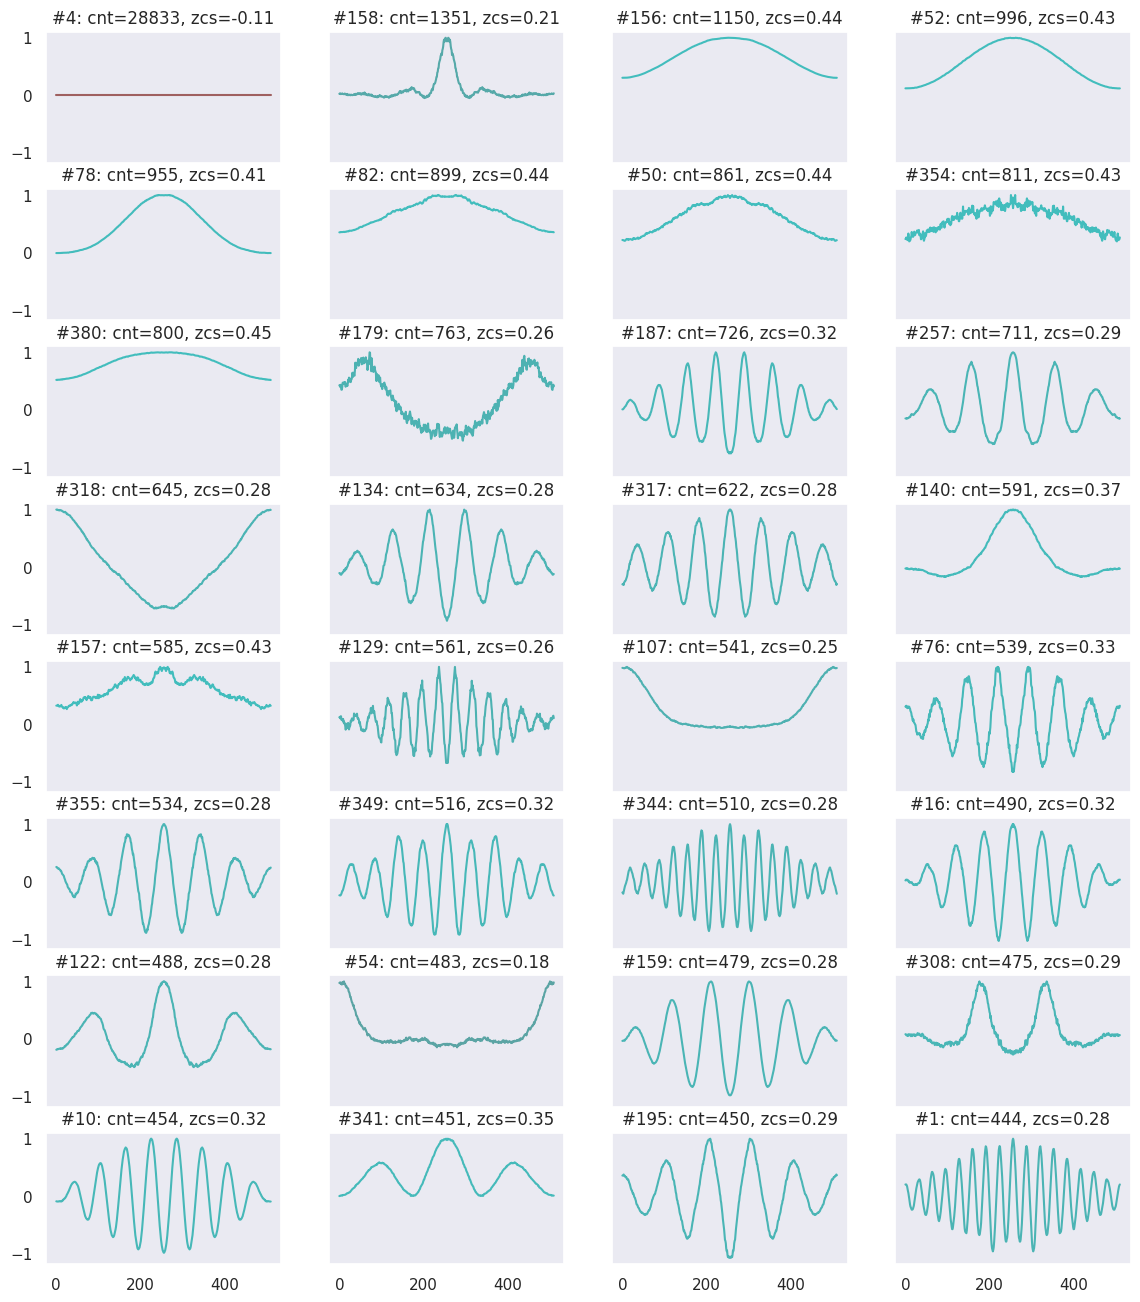

In [143]:
hap_top_counter = hap_tokens_counter.most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = hap_top_counter[i]
    ax.plot(masked_emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

In [144]:
ang_tokens = np.concatenate(df[df['emotion_key']=='ang']['tokens'].values)
ang_tokens_counter = Counter(ang_tokens)
ang_tokens_counter

Counter({4: 32302,
         156: 1525,
         158: 1440,
         82: 1187,
         52: 1070,
         78: 1042,
         50: 1032,
         354: 892,
         380: 816,
         179: 787,
         257: 734,
         318: 706,
         140: 676,
         187: 665,
         129: 624,
         157: 605,
         317: 574,
         134: 571,
         107: 547,
         54: 503,
         355: 502,
         16: 485,
         76: 478,
         308: 475,
         368: 458,
         344: 452,
         193: 452,
         122: 451,
         1: 443,
         349: 439,
         341: 427,
         181: 390,
         195: 386,
         90: 383,
         221: 382,
         271: 382,
         222: 381,
         262: 380,
         274: 378,
         381: 377,
         254: 374,
         143: 372,
         364: 372,
         10: 371,
         14: 369,
         220: 368,
         166: 361,
         159: 360,
         136: 356,
         251: 354,
         219: 354,
         246: 345,
         204: 345,

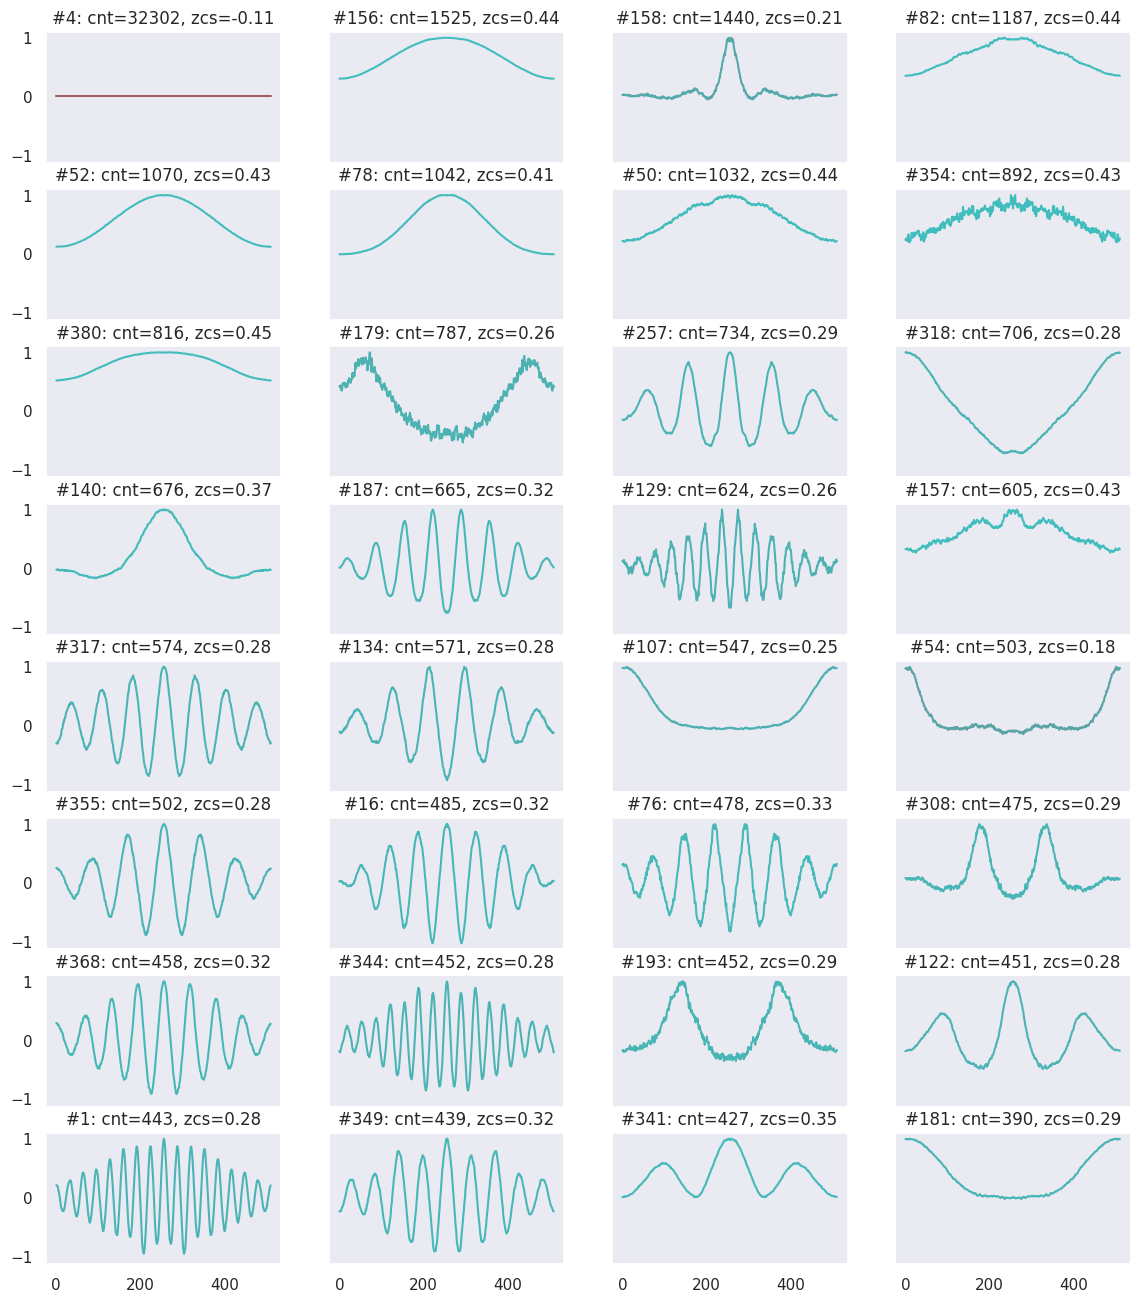

In [146]:
ang_top_counter = ang_tokens_counter.most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = ang_top_counter[i]
    ax.plot(masked_emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

In [147]:
sad_tokens = np.concatenate(df[df['emotion_key']=='sad']['tokens'].values)
sad_tokens_counter = Counter(sad_tokens)
sad_tokens_counter

Counter({4: 30264,
         156: 1370,
         158: 1278,
         52: 998,
         78: 955,
         129: 922,
         82: 898,
         187: 844,
         90: 800,
         317: 789,
         380: 761,
         179: 760,
         50: 754,
         134: 702,
         257: 696,
         140: 678,
         318: 632,
         76: 628,
         143: 587,
         122: 579,
         107: 577,
         355: 575,
         308: 531,
         354: 527,
         16: 524,
         54: 517,
         349: 506,
         254: 500,
         368: 493,
         10: 465,
         344: 461,
         1: 432,
         271: 428,
         221: 425,
         371: 398,
         181: 398,
         22: 395,
         106: 395,
         157: 394,
         262: 393,
         79: 392,
         159: 385,
         303: 385,
         219: 384,
         220: 380,
         160: 379,
         195: 377,
         32: 366,
         108: 364,
         231: 358,
         191: 357,
         97: 355,
         193: 350,
      

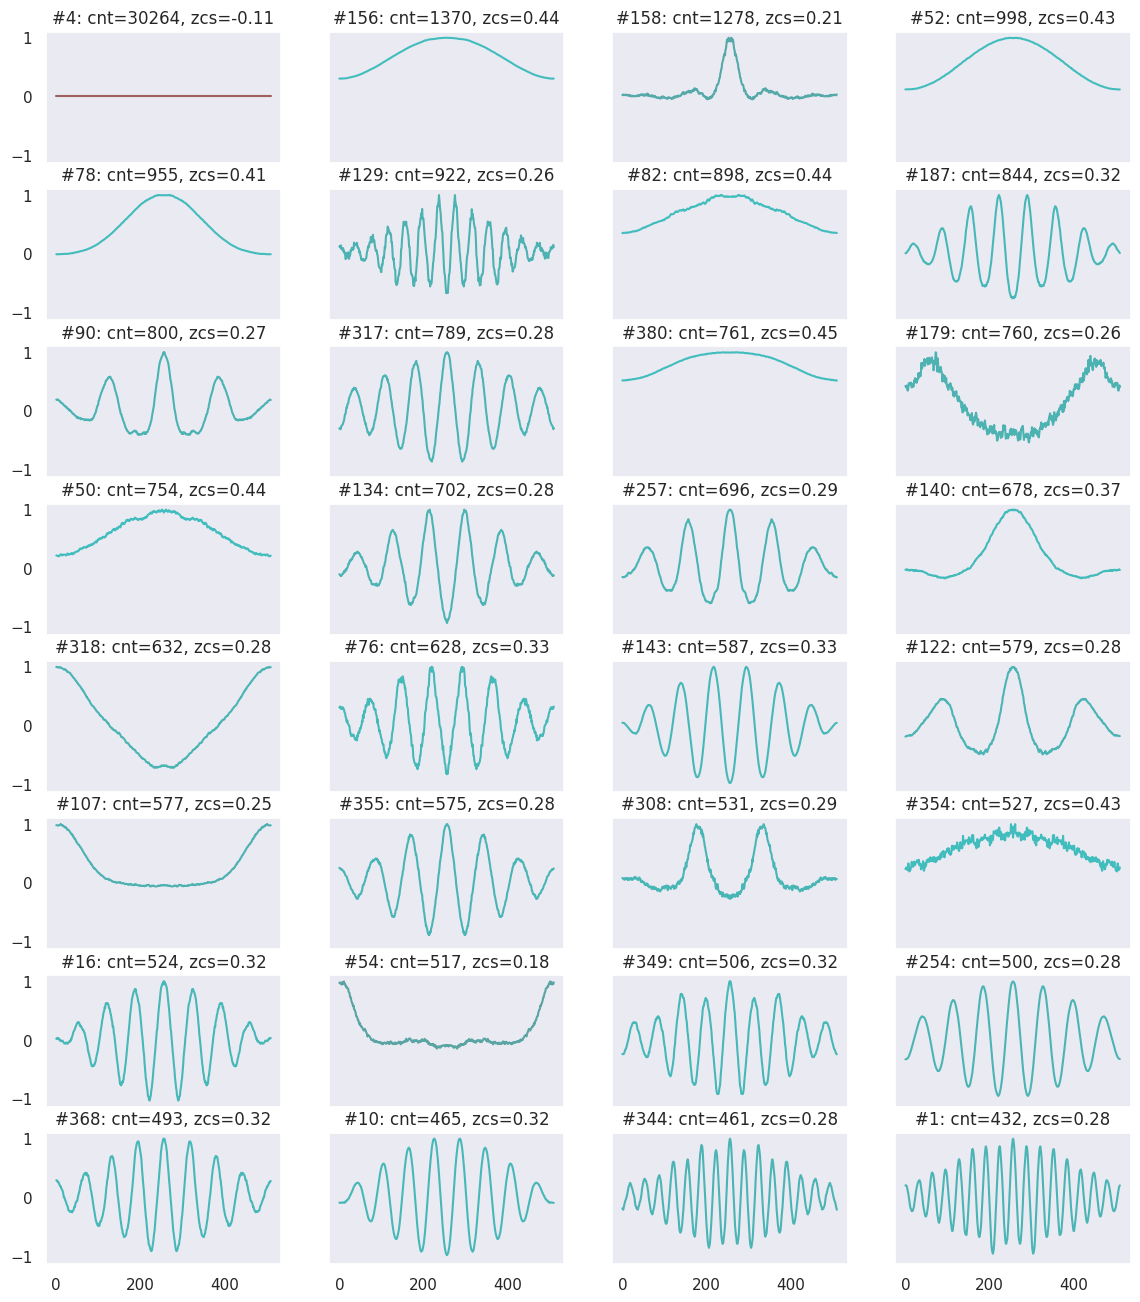

In [148]:
sad_top_counter = sad_tokens_counter.most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = sad_top_counter[i]
    ax.plot(masked_emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

In [149]:
neu_tokens = np.concatenate(df[df['emotion_key']=='neu']['tokens'].values)
neu_tokens_counter = Counter(neu_tokens)
neu_tokens_counter

Counter({4: 14134,
         158: 695,
         257: 549,
         78: 528,
         122: 503,
         52: 461,
         134: 442,
         140: 439,
         179: 401,
         318: 388,
         159: 386,
         67: 379,
         90: 374,
         187: 370,
         193: 349,
         355: 332,
         107: 325,
         329: 325,
         308: 324,
         129: 320,
         195: 314,
         54: 302,
         317: 296,
         77: 295,
         198: 284,
         221: 277,
         298: 269,
         76: 265,
         181: 259,
         380: 256,
         243: 242,
         16: 242,
         121: 239,
         50: 239,
         220: 236,
         115: 234,
         156: 225,
         82: 224,
         143: 218,
         344: 215,
         254: 213,
         192: 207,
         125: 207,
         1: 204,
         315: 201,
         89: 188,
         22: 187,
         108: 181,
         231: 181,
         309: 181,
         262: 180,
         241: 180,
         368: 179,
       

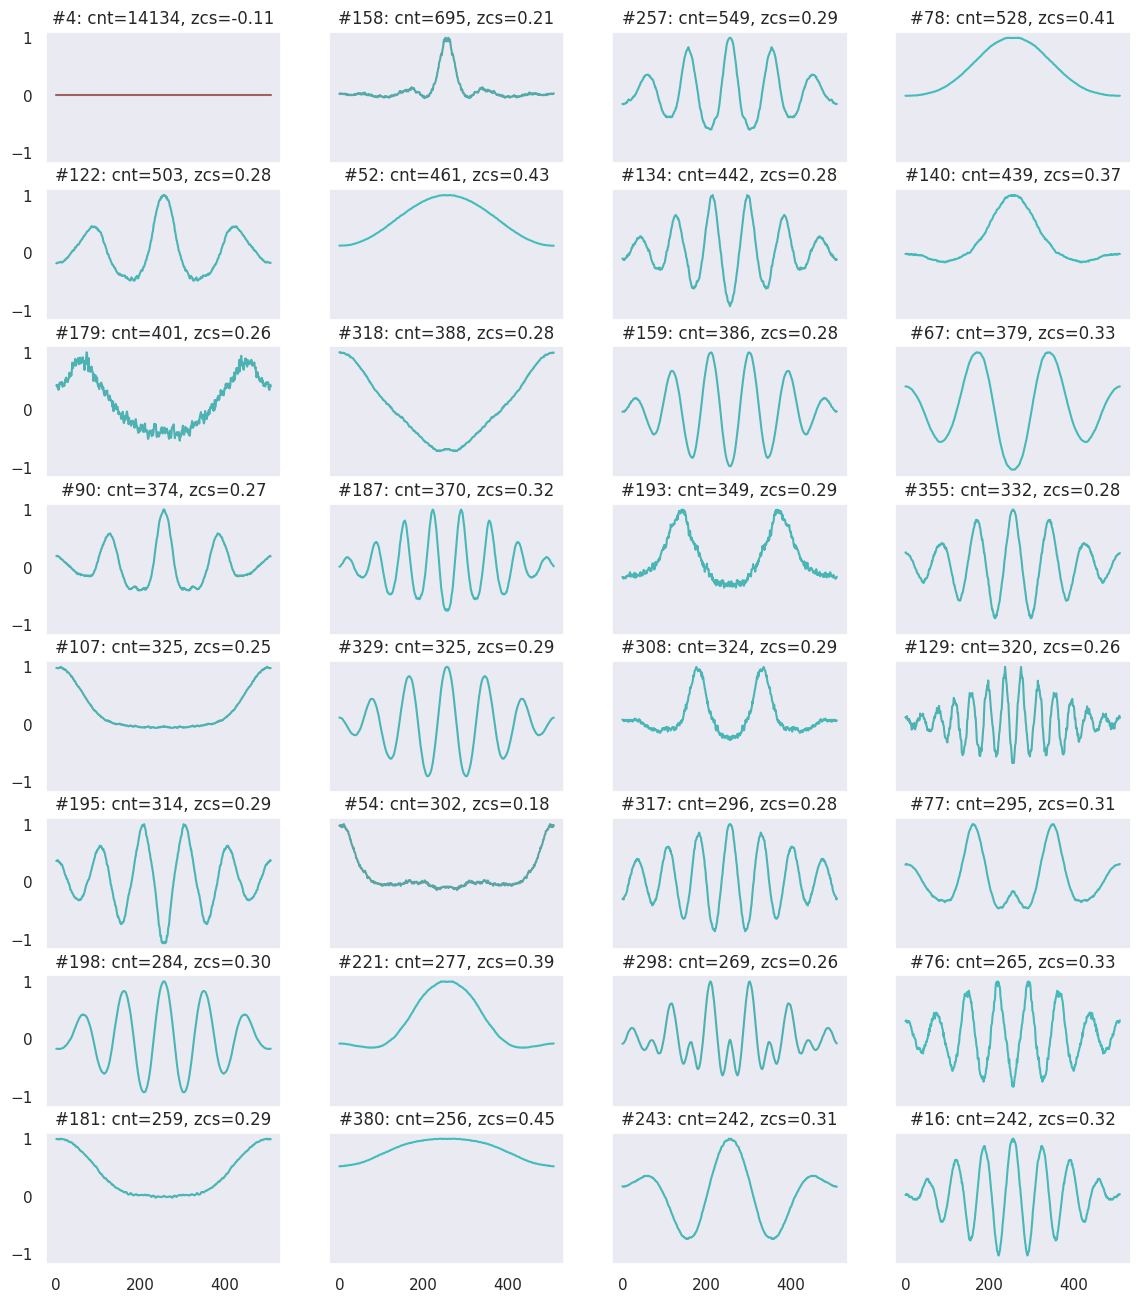

In [150]:
neu_top_counter = neu_tokens_counter.most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = neu_top_counter[i]
    ax.plot(masked_emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')